In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# ----------------------------------------------------------------------
# 1. Load environment (for DB_URL) and connect to the database
# ----------------------------------------------------------------------
load_dotenv()
DB_URL = os.getenv("DB_URL", "sqlite:///weather.db")

# If using SQLite, strip off "sqlite:///" to get the file path
if DB_URL.startswith("sqlite:///"):
    db_path = DB_URL.replace("sqlite:///", "")
else:
    db_path = DB_URL

conn = sqlite3.connect(db_path)

# ----------------------------------------------------------------------
# 2. Read and prepare the full weather dataset
# ----------------------------------------------------------------------
df_weather = pd.read_sql(
    """
    SELECT
        fw.obs_ts,
        fw.temp_c,
        fw.feels_like_c,
        fw.humidity_pct,
        fw.pressure_hpa,
        fw.wind_speed_ms,
        fw.clouds_pct,
        dl.city_name,
        fw.weather_main,
        fw.weather_desc
    FROM fact_weather AS fw
    JOIN dim_location AS dl
      ON fw.location_id = dl.location_id
    """,
    conn
)
conn.close()

# Convert obs_ts (string) → UTC datetime, set as index
df_weather["obs_ts"] = pd.to_datetime(
    df_weather["obs_ts"],
    format="%Y-%m-%d %H:%M:%S.%f",
    utc=True,
    errors="coerce"
)
df_weather.set_index("obs_ts", inplace=True)

# Display a snapshot of the data
print("Raw Weather Data (first 5 rows):")
print(df_weather.head(), "\n")

# ----------------------------------------------------------------------
# 3. Descriptive Statistics by City
# ----------------------------------------------------------------------
stats_by_city = df_weather.groupby("city_name").agg({
    "temp_c":        ["mean", "min", "max", "std"],
    "feels_like_c":  ["mean", "min", "max", "std"],
    "humidity_pct":  ["mean", "min", "max", "std"],
    "pressure_hpa":  ["mean", "min", "max", "std"],
    "wind_speed_ms": ["mean", "min", "max", "std"],
    "clouds_pct":    ["mean", "min", "max", "std"]
})
# Flatten MultiIndex column names
stats_by_city.columns = ["_".join(col).strip() for col in stats_by_city.columns.values]

print("Descriptive Statistics by City:")
print(stats_by_city, "\n")

# ----------------------------------------------------------------------
# 4. Correlation Matrix Among Numerical Features
# ----------------------------------------------------------------------
numeric_cols = [
    "temp_c",
    "feels_like_c",
    "humidity_pct",
    "pressure_hpa",
    "wind_speed_ms",
    "clouds_pct"
]
corr_matrix = df_weather[numeric_cols].corr()

print("Correlation Matrix:")
print(corr_matrix, "\n")


Raw Weather Data (first 5 rows):
        temp_c  feels_like_c  humidity_pct  pressure_hpa  wind_speed_ms  \
obs_ts                                                                    
NaT      29.51          32.1            61          1009           7.17   
NaT      29.51          32.1            61          1009           7.17   
NaT      29.51          32.1            61          1009           7.17   
NaT      29.51          32.1            61          1009           7.17   
NaT      29.51          32.1            61          1009           7.17   

        clouds_pct  city_name weather_main     weather_desc  
obs_ts                                                       
NaT             98  Bengaluru       Clouds  overcast clouds  
NaT             98  Bengaluru       Clouds  overcast clouds  
NaT             98  Bengaluru       Clouds  overcast clouds  
NaT             98  Bengaluru       Clouds  overcast clouds  
NaT             98  Bengaluru       Clouds  overcast clouds   

Descr

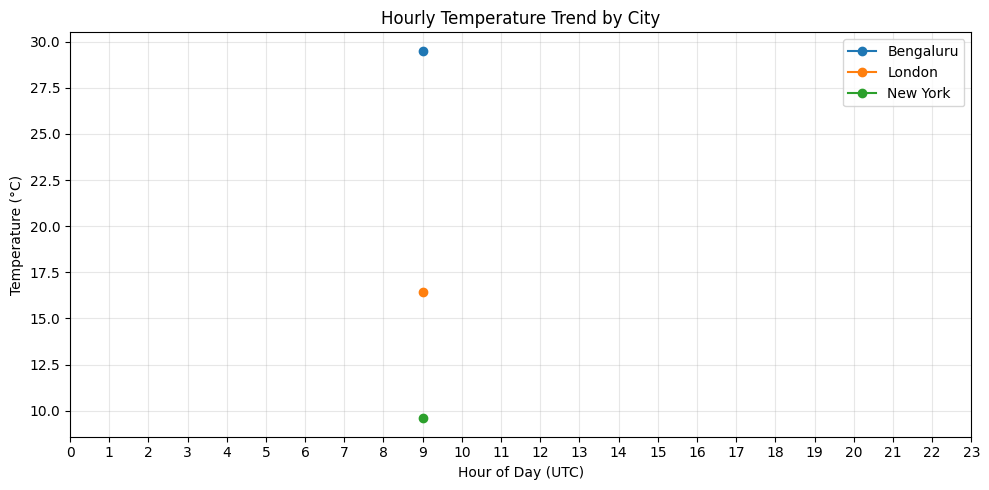

In [2]:
# ----------------------------------------------------------------------
# 5. Hourly Temperature Trend by City
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 5))
for city, group in df_weather.groupby('city_name'):
    hourly_mean = group['temp_c'].resample('H').mean()
    plt.plot(hourly_mean.index.hour, hourly_mean.values, marker='o', label=city)

plt.title("Hourly Temperature Trend by City")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Temperature (°C)")
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


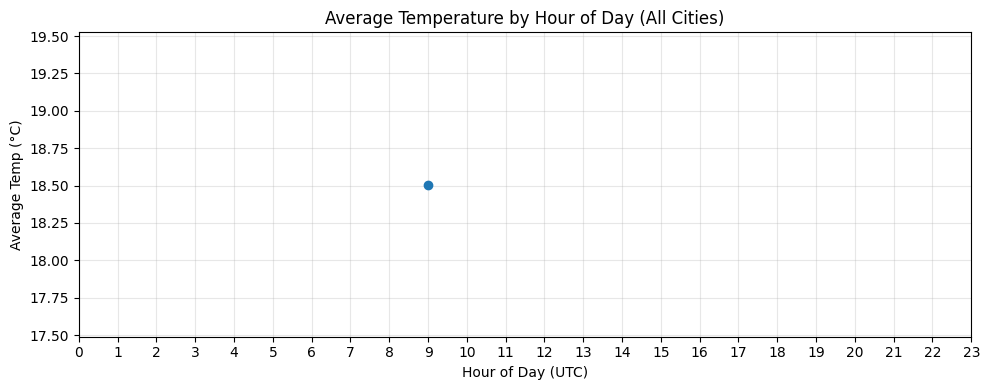

In [3]:

# ----------------------------------------------------------------------
# 6. Average Temperature by Hour of Day (All Cities)
# ----------------------------------------------------------------------
df_weather['hour_utc'] = df_weather.index.hour
hourly_avg_all = df_weather.groupby('hour_utc')['temp_c'].mean().reindex(range(24))

plt.figure(figsize=(10, 4))
plt.plot(hourly_avg_all.index, hourly_avg_all.values, marker='o', linestyle='-')
plt.title("Average Temperature by Hour of Day (All Cities)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Average Temp (°C)")
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


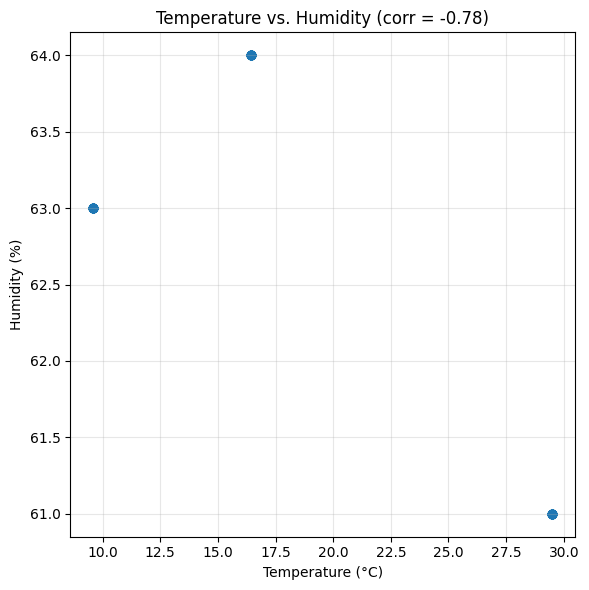

In [4]:

# ----------------------------------------------------------------------
# 7. Scatterplot: Temperature vs. Humidity with Correlation
# ----------------------------------------------------------------------
df_scatter = df_weather.dropna(subset=['temp_c', 'humidity_pct'])
corr_temp_humidity = df_scatter['temp_c'].corr(df_scatter['humidity_pct'])

plt.figure(figsize=(6, 6))
plt.scatter(df_scatter['temp_c'], df_scatter['humidity_pct'], alpha=0.7)
plt.title(f"Temperature vs. Humidity (corr = {corr_temp_humidity:.2f})")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Daily Mean Temperature & Humidity:
                              temp_c  humidity_pct
obs_ts                                            
2025-06-01 00:00:00+00:00  18.506667     62.666667 



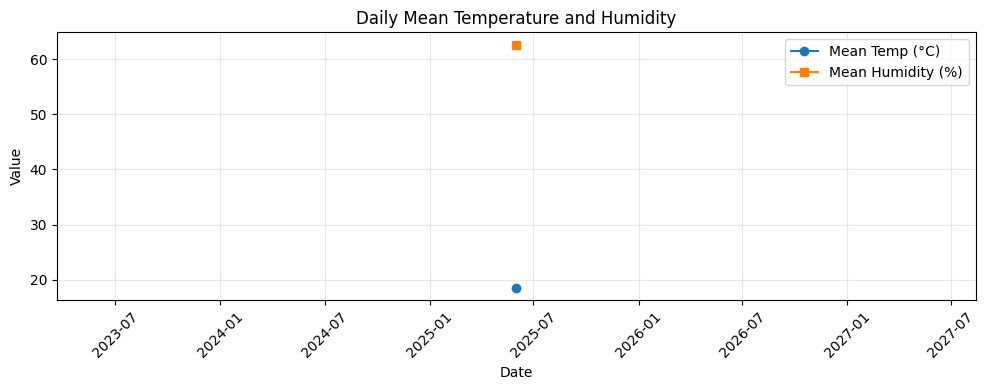

In [5]:
# 9. Daily Aggregates: Mean Temperature and Humidity
# ----------------------------------------------------------------------
daily_stats = df_weather.resample('D').agg({
    'temp_c':       'mean',
    'humidity_pct': 'mean'
})

print("Daily Mean Temperature & Humidity:")
print(daily_stats, "\n")

plt.figure(figsize=(10, 4))
plt.plot(daily_stats.index, daily_stats['temp_c'], marker='o', label='Mean Temp (°C)')
plt.plot(daily_stats.index, daily_stats['humidity_pct'], marker='s', label='Mean Humidity (%)')
plt.title("Daily Mean Temperature and Humidity")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# -------------------------------------------------------
# 1. Connect to SQLite and load the weather table
# -------------------------------------------------------
conn = sqlite3.connect('weather.db')

df_weather = pd.read_sql("""
    SELECT
        fw.obs_ts,
        fw.temp_c,
        fw.feels_like_c,
        fw.humidity_pct,
        fw.pressure_hpa,
        fw.wind_speed_ms,
        fw.clouds_pct,
        dl.city_name,
        fw.weather_main,
        fw.weather_desc
    FROM fact_weather AS fw
    JOIN dim_location AS dl 
      ON fw.location_id = dl.location_id
""", conn)

conn.close()

# Convert obs_ts (string) → UTC datetime and set as index
# Use format matching "YYYY-MM-DD HH:MM:SS.microseconds"
df_weather['obs_ts'] = pd.to_datetime(
    df_weather['obs_ts'],
    format="%Y-%m-%d %H:%M:%S.%f",
    utc=True,
    errors="coerce"
)
df_weather.set_index('obs_ts', inplace=True)

# Display DataFrame info and sample
print(">>> DataFrame info:")
print(df_weather.info(), "\n")
print(">>> First 5 rows:")
print(df_weather.head(), "\n")



>>> DataFrame info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78 entries, NaT to 2025-06-01 09:11:20+00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_c         78 non-null     float64
 1   feels_like_c   78 non-null     float64
 2   humidity_pct   78 non-null     int64  
 3   pressure_hpa   78 non-null     int64  
 4   wind_speed_ms  78 non-null     float64
 5   clouds_pct     78 non-null     int64  
 6   city_name      78 non-null     object 
 7   weather_main   78 non-null     object 
 8   weather_desc   78 non-null     object 
dtypes: float64(3), int64(3), object(3)
memory usage: 6.1+ KB
None 

>>> First 5 rows:
        temp_c  feels_like_c  humidity_pct  pressure_hpa  wind_speed_ms  \
obs_ts                                                                    
NaT      29.51          32.1            61          1009           7.17   
NaT      29.51          32.1            61          10

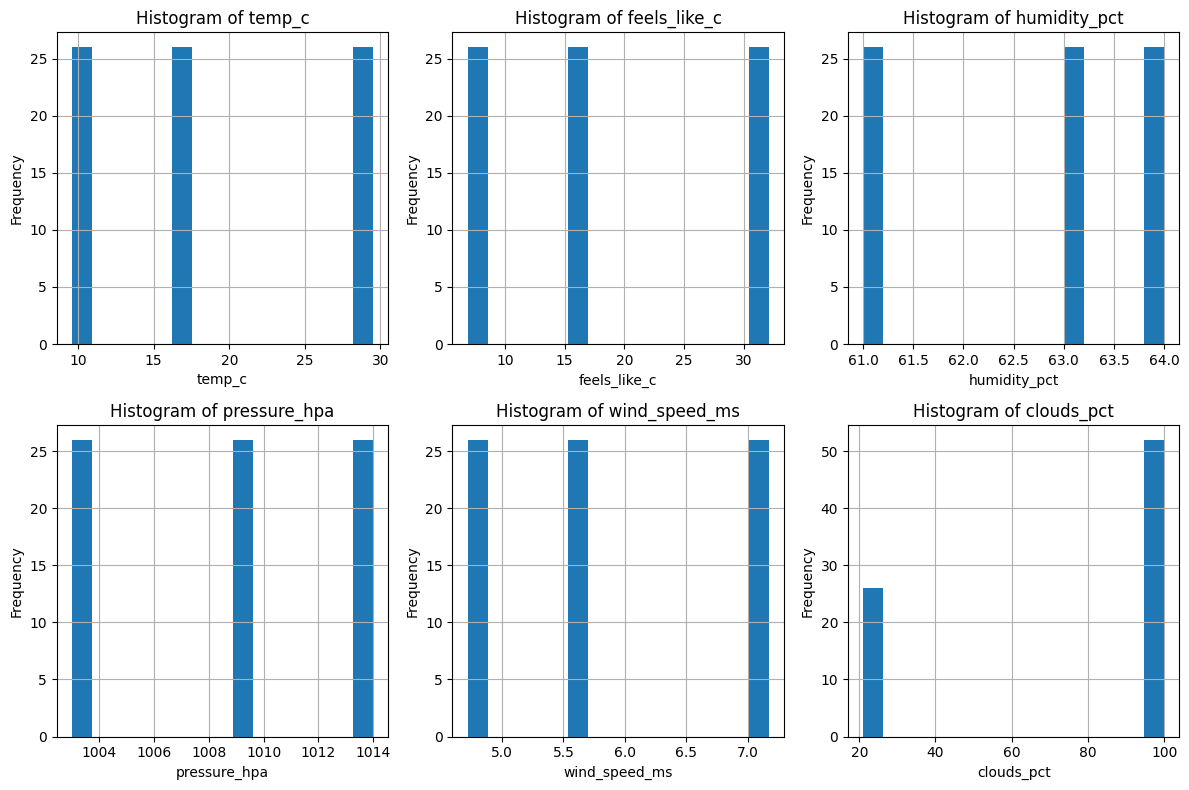

In [7]:
# -------------------------------------------------------
# 2. Histograms of Numeric Features
# -------------------------------------------------------
numeric_cols = [
    'temp_c',
    'feels_like_c',
    'humidity_pct',
    'pressure_hpa',
    'wind_speed_ms',
    'clouds_pct'
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    df_weather[col].hist(bins=15)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

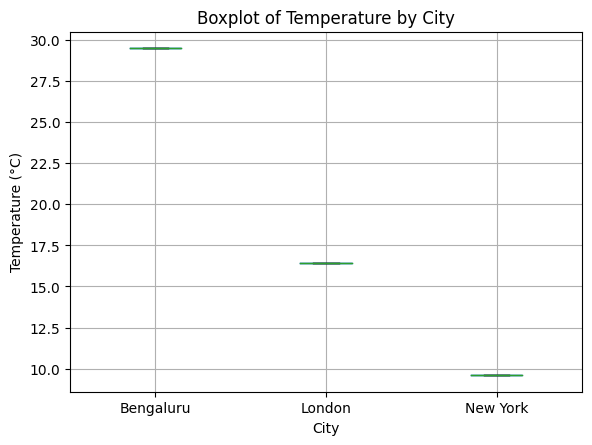

In [8]:

# -------------------------------------------------------
# 3. Boxplots by City: Temperature and Humidity
# -------------------------------------------------------
plt.figure(figsize=(10, 5))
df_weather.boxplot(column='temp_c', by='city_name')
plt.title('Boxplot of Temperature by City')
plt.suptitle('')
plt.xlabel('City')
plt.ylabel('Temperature (°C)')
plt.show()


<Figure size 1000x500 with 0 Axes>

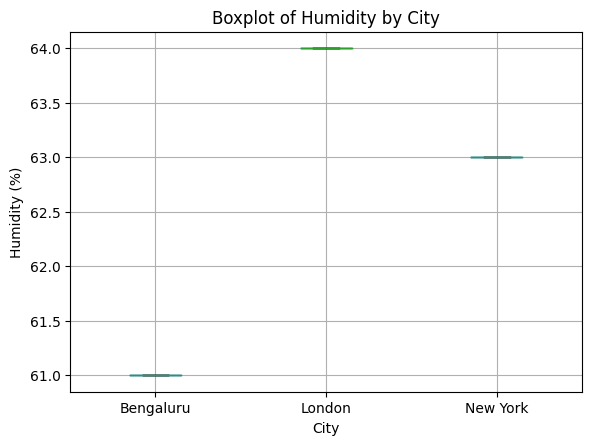

In [9]:

plt.figure(figsize=(10, 5))
df_weather.boxplot(column='humidity_pct', by='city_name')
plt.title('Boxplot of Humidity by City')
plt.suptitle('')
plt.xlabel('City')
plt.ylabel('Humidity (%)')
plt.show()


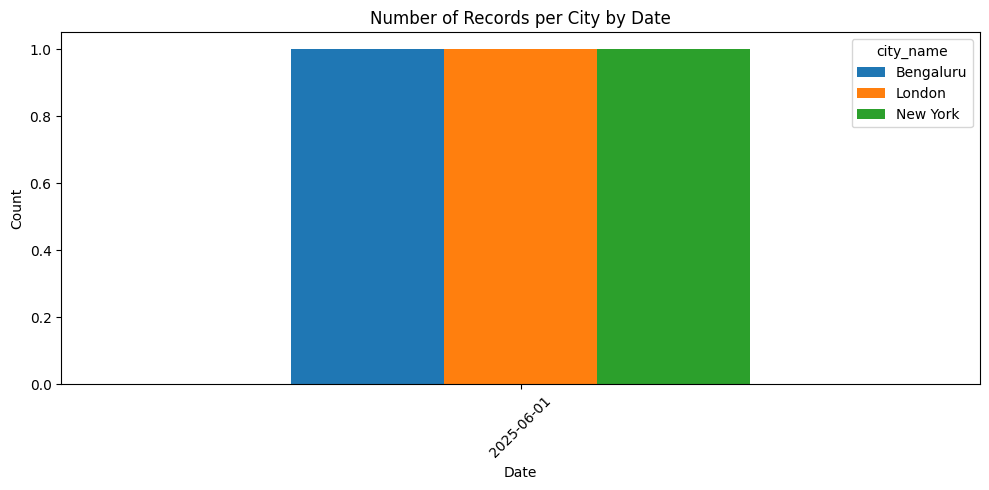

In [10]:

# -------------------------------------------------------
# 4. Bar Chart: Record Counts per City by Date
# -------------------------------------------------------
counts = df_weather.groupby([df_weather.index.date, 'city_name']).size().unstack(fill_value=0)
counts.plot(kind='bar', figsize=(10, 5))
plt.title('Number of Records per City by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


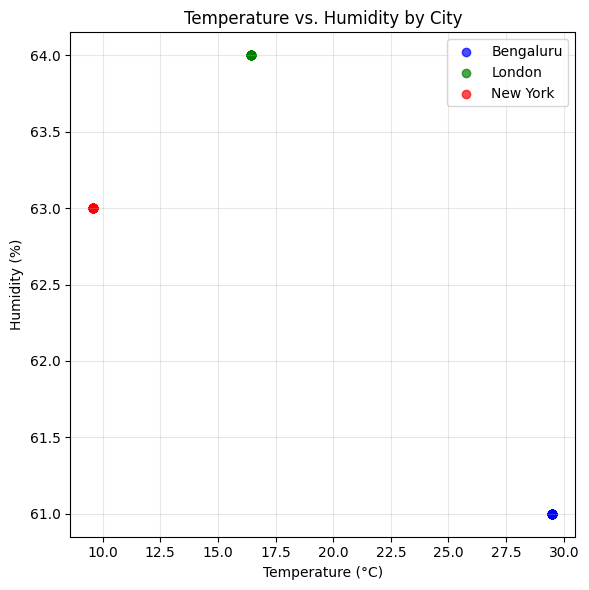

In [11]:
# -------------------------------------------------------
# 6. Scatterplot: Temperature vs. Humidity by City
# -------------------------------------------------------
plt.figure(figsize=(6, 6))
colors = {'Bengaluru': 'blue', 'London': 'green', 'New York': 'red'}
for city in df_weather['city_name'].unique():
    subset = df_weather[df_weather['city_name'] == city]
    plt.scatter(subset['temp_c'], subset['humidity_pct'], 
                label=city, alpha=0.7, c=colors.get(city, 'gray'))
plt.title('Temperature vs. Humidity by City')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()